In [1]:
from dataLoadersXR import TX1day_train

train = TX1day_train(address = '/net/litho/atmosdyn2/mfroelich/TS_TX1day_mean-lvl',
                     forecast_steps = 2,
                     year_subset = [2000,2001], location_subset = None)

In [3]:
from torch.utils.data import DataLoader
import numpy as np

train_loader = DataLoader(train, batch_size=1000, shuffle=True)

In [5]:
len(train_loader)

260

In [3]:
x = next(iter(train_loader))

In [10]:
x['input'].shape

torch.Size([1000, 119, 3])

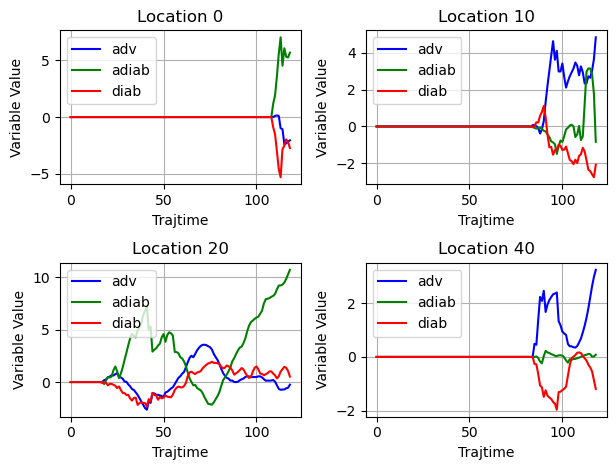

In [4]:
stacked_array = x['input'].numpy()
trajtime = np.arange(stacked_array.shape[1])

import matplotlib.pyplot as plt
# Loop over locations and plot
for i, loc in enumerate([0,10,20,40]):
    adv_data = stacked_array[loc, :, 0]
    adiab_data = stacked_array[loc, :, 1]
    diab_data = stacked_array[loc, :, 2]
    
    plt.subplot(2, 2, i+1)  # Create a 2x2 grid of subplots
    
    plt.plot(trajtime, adv_data, label='adv', color='blue')
    plt.plot(trajtime, adiab_data, label='adiab', color='green')
    plt.plot(trajtime, diab_data, label='diab', color='red')
    
    plt.xlabel('Trajtime')
    plt.ylabel('Variable Value')
    plt.title(f'Location {loc}')
    plt.legend()
    plt.grid(True)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [1]:
from dataLoadersXR import TX1day_val

train = TX1day_val(address = '/net/litho/atmosdyn2/mfroelich/TS_TX1day_mean-lvl',
                     forecast_steps = 2,
                     year_subset = [2000,2001], location_subset = None)

In [12]:
val_loader = DataLoader(train,batch_size=200,shuffle=True)

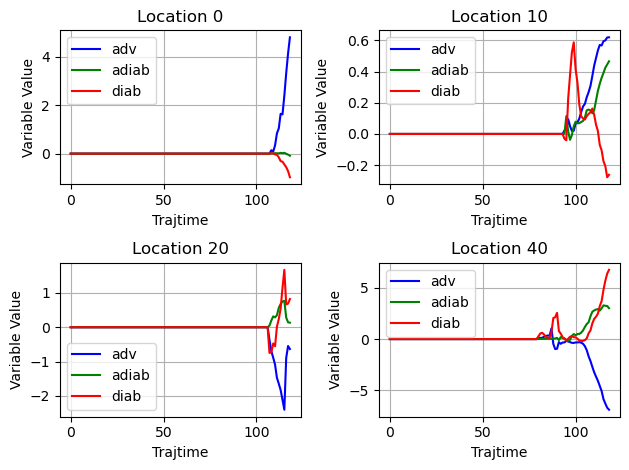

In [13]:
x = next(iter(val_loader))
stacked_array = x['input'].numpy()
trajtime = np.arange(stacked_array.shape[1])

import matplotlib.pyplot as plt
# Loop over locations and plot
for i, loc in enumerate([0,10,20,40]):
    adv_data = stacked_array[loc, :, 0]
    adiab_data = stacked_array[loc, :, 1]
    diab_data = stacked_array[loc, :, 2]
    
    plt.subplot(2, 2, i+1)  # Create a 2x2 grid of subplots
    
    plt.plot(trajtime, adv_data, label='adv', color='blue')
    plt.plot(trajtime, adiab_data, label='adiab', color='green')
    plt.plot(trajtime, diab_data, label='diab', color='red')
    
    plt.xlabel('Trajtime')
    plt.ylabel('Variable Value')
    plt.title(f'Location {loc}')
    plt.legend()
    plt.grid(True)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
x['idx'][[0,10,20,40],:]

tensor([[ -57.5000, -130.5000, 2001.0000],
        [  37.0000, -137.5000, 2000.0000],
        [  24.0000, -156.5000, 2000.0000],
        [  35.5000, -102.0000, 2001.0000]], dtype=torch.float64)

In [15]:
len(train)

159040

In [18]:
example_locations = list(np.linspace(0,60000,9).astype(int))

In [19]:
example_locations

[0, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000]

In [5]:
import numpy as np
np.load('/home/mfroelich/Thesis/LSTM_results/trial_run2/losses/64_1e-05_val_losses.npy')

array([21.69170616, 21.87575825])

In [8]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

from matplotlib.ticker import FixedFormatter, FixedLocator

import dask 

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Paths
indir = '/net/litho/atmosdyn/roethlim/data/lastvar/era5/upload/TX1day/data/figures/'
infile = 'TX1day_decomposition_era5_v10_final.nc'
outdir = '/home/mfroelich/Thesis/figure_dir/plots/'

mapping = {'Adv':13/14,'Adv/Adiab':11/14,'Adiab/Adv':11/14,
           'Adiab':9/14,'Adiab/Diab':7/14,'Diab/Adiab':7/14,
           'Diab':5/14,'Adv/Diab':3/14,'Diab/Adv':3/14,
           'all three':1/14}

def dominant_mean(var1,var2,var3):
    names = ['Adv','Adiab','Diab']
    vars = [var1,var2,var3]
    ret = np.flip(np.argsort(vars))
    if vars[ret[0]] >= 2*vars[ret[1]]:
        dom = names[ret[0]]
    else:
        if vars[ret[0]] > 0 and vars[ret[1]] > 0 and vars[ret[2]] < 0:
            dom = names[ret[0]] + '/' + names[ret[1]]
        else:
            dom = 'all three'
        
    return mapping.get(dom,np.nan)

def dominant_var(var1,var2,var3):
    names = ['Adv','Adiab','Diab']
    vars = [var1,var2,var3]
    ret = np.flip(np.argsort(vars))
    if vars[ret[0]] >= 2*vars[ret[1]]:
        dom = names[ret[0]]
    else:
        if vars[ret[1]] >= 2*vars[ret[2]]:
            dom = names[ret[0]] + '/' + names[ret[1]]
        else:
            dom = 'all three'
        
    return mapping.get(dom,np.nan)

# VAR
indir_comp = '/home/mfroelich/Thesis/data/covariance/components.nc'
var = xr.open_dataset(indir_comp)

indir_t = '/home/mfroelich/Thesis/data/covariance/t_anom.nc'
var_t = xr.open_dataset(indir_t)

xr_in = xr.open_dataset(indir + '/' + infile,chunks = {'years' : 42,'lon': 242, 'lat': 182}).mean(dim='lev',skipna=True)
xr_in = xr_in.drop_sel(years = 1979)
mean = xr_in.mean(dim='years')

mean = xr.apply_ufunc(dominant_mean,
                            mean['adv'],mean['adiab'],mean['diab'],
                            input_core_dims=[[],[],[]],
                            output_core_dims=[[]],
                            vectorize=True,
                            dask='parallelized', # since func converts to numpy.array
                            output_dtypes=['float'])

var = xr.apply_ufunc(dominant_var, 
                     var['adv'],var['adiab'],var['diab'],
                     input_core_dims=[[],[],[]],
                        output_core_dims=[[]],
                        vectorize=True,
                        dask='parallelized', # since func converts to numpy.array
                        output_dtypes=['float'])

In [11]:
mean

<xarray.DataArray (lat: 361, lon: 721)> Size: 2MB
dask.array<transpose, shape=(361, 721), dtype=float64, chunksize=(182, 242), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 6kB -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0

In [24]:
condition = mean == 5/14
lat_coords, lon_coords = np.meshgrid(mean.lat, mean.lon, indexing='ij')
matching_lat = lat_coords[condition]
matching_lon = lon_coords[condition]

# Combine lat and lon coordinates into a list of tuples
coords = list(zip(matching_lat, matching_lon))

In [26]:
condition2 = var == 11/14
lat_coords, lon_coords = np.meshgrid(mean.lat, mean.lon, indexing='ij')
matching_lat = lat_coords[condition2]
matching_lon = lon_coords[condition2]

# Combine lat and lon coordinates into a list of tuples
coords2 = list(zip(matching_lat, matching_lon))

In [27]:
common_coords = set(coords).intersection(set(coords2))
common_coords = list(common_coords)

In [32]:
final = []
for (lat,lon) in common_coords:
    if lat < 30 and lat > 10 and lon < 60 and lon > 30:
        final.append((lat,lon))

In [35]:
final

[(18.0, 44.0),
 (18.5, 43.0),
 (18.5, 43.5),
 (19.5, 44.0),
 (25.0, 43.5),
 (26.5, 42.0),
 (21.0, 41.0),
 (14.5, 45.5),
 (18.5, 42.5),
 (25.0, 42.5),
 (25.5, 41.5),
 (14.5, 31.5),
 (22.5, 44.0),
 (22.5, 44.5),
 (17.0, 52.5),
 (24.0, 41.5),
 (17.0, 47.0),
 (17.5, 55.0),
 (20.0, 57.0),
 (20.0, 57.5),
 (16.0, 32.0),
 (24.0, 45.0),
 (24.0, 45.5),
 (28.0, 42.0),
 (28.0, 42.5),
 (28.5, 41.0),
 (28.5, 41.5),
 (13.0, 31.0),
 (27.0, 41.5),
 (27.0, 41.0),
 (19.0, 46.0),
 (19.0, 46.5),
 (21.5, 42.0),
 (20.0, 47.0),
 (23.0, 43.0),
 (23.0, 43.5),
 (16.0, 31.5),
 (24.0, 44.5),
 (24.5, 43.0),
 (24.5, 43.5),
 (16.5, 48.0),
 (16.5, 48.5),
 (20.5, 41.5),
 (23.5, 46.5),
 (13.0, 30.5),
 (27.0, 40.0),
 (27.0, 40.5),
 (19.0, 45.5),
 (23.5, 41.5),
 (16.0, 30.5),
 (15.0, 34.0),
 (15.0, 34.5),
 (24.5, 42.5),
 (16.5, 47.0),
 (13.5, 32.0),
 (23.5, 45.0),
 (23.5, 45.5),
 (22.0, 59.0),
 (19.0, 44.0),
 (19.0, 44.5),
 (19.5, 43.0),
 (20.5, 44.5),
 (26.5, 41.0),
 (26.5, 41.5),
 (18.5, 46.0),
 (18.5, 46.5),
 (27.5, 42

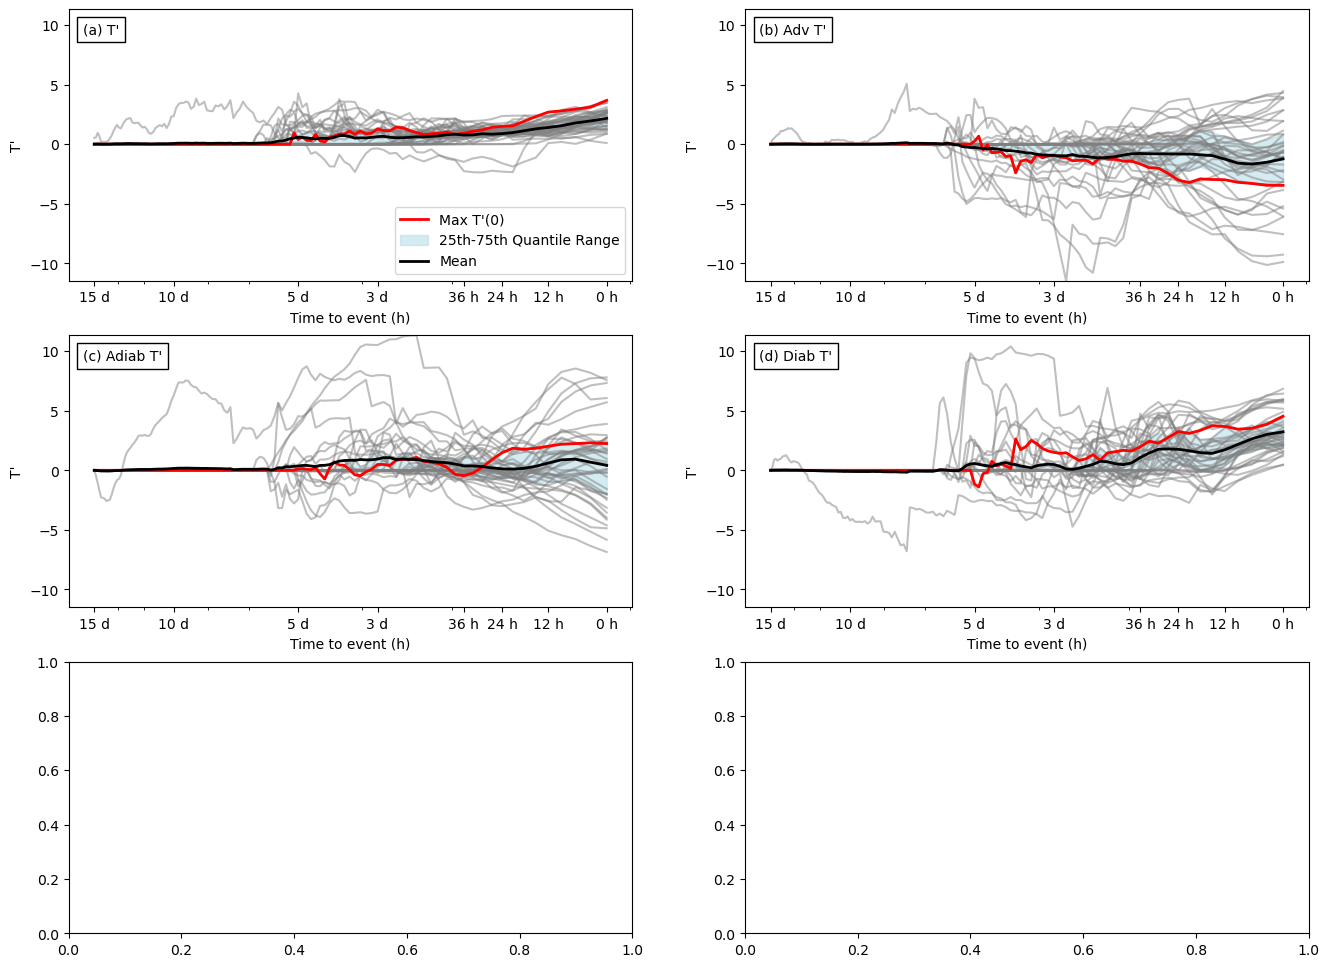

In [37]:
subselection = [(14.5, 46.0), (16.5, 47.0), (17.5, 55.0),(14.5, 45.5)]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from scipy.signal import correlate
import matplotlib.gridspec as gridspec

from matplotlib import colors as mcolors

import xarray as xr

num_years = 41
lags = 16
# vicinity of Madrid, Spain (40.5N, 3.5W)
# vicinity of New Dehli, India (28.5N, 77E)
# vicinity of Brazilia, Brazil (16S, 48W)

# mid-atlantic ocean (45N, 30W)
# vicinity of Santa Cruz de la Sierra, Bolivia (17.5S, 63.5W)
lat = subselection[0][0]
lon = subselection[0][1]
address = '/net/litho/atmosdyn2/mfroelich/TS_TX1day_mean-lvl'
outdir = '/home/mfroelich/Thesis/figure_dir/plots/'

ds = xr.open_dataset(address,chunks={'year':1,'lat':181,'lon':361,'trajtime':121})[['T_anom','adv','adiab','diab']]
ds = ds.fillna(0)
ds = ds.sel({'lat':lat,'lon':lon},drop=True)
ds = ds.sel({'year':list(np.arange(1980,2021,1)[:num_years])})

data = np.stack([ds['T_anom'].values,
                 ds['adv'].values,
                 ds['adiab'].values,
                 ds['diab'].values], axis=-1)

# Compute global min and max for y-axis limits
global_min = data.min()
global_max = data.max()

# Calculate mean and quantiles across the first dimension (40 timeseries)
mean = np.mean(data, axis=0)              # Shape: (120, 4)
quantile_25 = np.quantile(data, 0.25, axis=0)  # Shape: (120, 4)
quantile_75 = np.quantile(data, 0.75, axis=0)  # Shape: (120, 4)

# Identify the index of the timeseries with the largest final value in the first graph (dimension 0)
max_idx = np.argmax(data[:, -1, 0])

# Create a figure with a specified size
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# Define axes for timeseries plots
ax_ts_1 = fig.add_subplot(gs[0, 0])
ax_ts_2 = fig.add_subplot(gs[0, 1])
ax_ts_3 = fig.add_subplot(gs[1, 0])
ax_ts_4 = fig.add_subplot(gs[1, 1])

# Define axes for correlation plots
ax_auto = fig.add_subplot(gs[2, 0])
ax_cross = fig.add_subplot(gs[2, 1])

# List of axes for easier iteration
timeseries_axes = [ax_ts_1, ax_ts_2, ax_ts_3, ax_ts_4]
names = ['(a) T\'','(b) Adv T\'','(c) Adiab T\'','(d) Diab T\'']

x_domain = np.linspace(10,1,num=121)
x_ticks = [x_domain[y] for y in [0, 40, 80, 96, 108, 112, 116, 120]]
x_labels = ['15 d', '10 d', '5 d', '3 d', '36 h', '24 h', '12 h', '0 h']

# Plot the four timeseries graphs
for i in range(4):
    ax = timeseries_axes[i]
    
    # Plot all 40 timeseries in grey
    for j in range(data.shape[0]):
        ax.plot(x_domain,data[j, :, i], color='grey', alpha=0.5)
    
    # Highlight the selected timeseries in red
    ax.plot(x_domain,data[max_idx, :, i], color='red', linewidth=2,label='Max T\'(0)') 
    
    ax.fill_between(x_domain,quantile_25[:, i], quantile_75[:, i], color='lightblue', alpha=0.5, label='25th-75th Quantile Range')
    ax.plot(x_domain,mean[:, i], color='black', linewidth=2, label='Mean')
    
    # Set titles and labels
    ax.text(0.025, 0.95, names[i], ha='left', va='top', transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='black'))
    ax.set_xlabel('Time to event (h)')
    ax.set_ylabel('T\'')
    
    # Set y-axis limits
    ax.set_ylim(global_min, global_max)
    ax.set_xscale('log')
    ax.invert_xaxis()

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    # Optional: Add legend only to the first plot to avoid clutter
    if i == 0:
        ax.legend(loc='lower right')

In [38]:
plt.show()

In [4]:
import numpy as np

np.load('/home/mfroelich/Thesis/LSTM_results/all_0.3dropout_2e6lr/losses/48_1e-06_val_losses.npy')

array([0.51004985, 0.47880526, 0.46716742, 0.45876938, 0.45095286,
       0.4457613 , 0.44334529, 0.44453841, 0.44765511, 0.45155135])

In [5]:
np.load('/home/mfroelich/Thesis/LSTM_results/all_0.2dropout_1e5lr/losses/64_0_val_losses.npy')

array([0.60025765, 0.57363241, 0.57595856, 0.57435222])

In [6]:
np.load('/home/mfroelich/Thesis/LSTM_results/all_0.3dropout_1e6lr/losses/48_0_val_losses.npy')

array([0.80699487, 0.70400701, 0.67209278, 0.65812834, 0.65045017,
       0.64432029, 0.63987312, 0.63569041, 0.62894314, 0.62640675,
       0.62315505, 0.62153426, 0.62120002, 0.62245991, 0.62038089])

In [8]:
import torch
import os
result_dir = '/home/mfroelich/Thesis/LSTM_results/'

# Load the saved model
model_path = os.path.join(result_dir, 'all_0.3dropout_1e6lr/models/model_48_0.pth')
model = torch.load(model_path)

In [28]:
for i, (key,value) in enumerate(model.state_dict().items()):
    print(f'{key}:{value.shape}')

lstm.weight_ih_l0:torch.Size([192, 3])
lstm.weight_hh_l0:torch.Size([192, 48])
lstm.bias_ih_l0:torch.Size([192])
lstm.bias_hh_l0:torch.Size([192])
linear.weight:torch.Size([24, 48])
linear.bias:torch.Size([24])


In [9]:
192/4

48.0

In [21]:
model.state_dict()['linear.bias']

tensor([-0.0262,  0.0670, -0.0483, -0.0428,  0.1343, -0.0373, -0.0185,  0.0292,
        -0.0062, -0.0818, -0.0283, -0.0281, -0.0008,  0.0376, -0.0445, -0.0159,
        -0.1194,  0.1362,  0.0238, -0.0549,  0.1624,  0.0315,  0.0552,  0.1450])

In [1]:
import torch
import os
result_dir = '/home/mfroelich/Thesis/LSTM_results/'

# Load the saved model
model_path = os.path.join(result_dir, 'all_0.3dropout_1e6lr/models/model_48_0.pth')
model = torch.load(model_path)
model.eval()

CustomLSTM(
  (lstm): LSTM(3, 48)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=48, out_features=24, bias=True)
)

In [2]:
from dataLoadersXR2 import TX1day_test
import joblib
import xarray as xr
import numpy as np

test_dir = '/net/litho/atmosdyn2/mfroelich/TS_TX1day_mean-lvl'
scalers = [joblib.load('/home/mfroelich/Thesis/LSTM_results/scalerAdv.gz'),
           joblib.load('/home/mfroelich/Thesis/LSTM_results/scalerAdiab.gz'),
           joblib.load('/home/mfroelich/Thesis/LSTM_results/scalerDiab.gz')]

ds = xr.open_dataset('/net/litho/atmosdyn2/mfroelich/TS_TX1day_mean-lvl')[['adv','adiab','diab']]
input = ds.sel({'year':2020,'lat':45,'lon':15},drop=True)
input = input.fillna(0)

adv = scalers[0].transform(input['adv'].values.reshape(-1,1)).squeeze()
adiab = scalers[1].transform(input['adiab'].values.reshape(-1,1)).squeeze()
diab = scalers[2].transform(input['diab'].values.reshape(-1,1)).squeeze()

input = torch.Tensor(np.stack((adv,adiab,diab),axis=1)).reshape(121,1,3)
inputs = input[:-8,:, :]
labels = input[-8:,:, :]

In [3]:
with torch.no_grad():
    mine, _ = model(inputs)

In [4]:
from LRP_forLSTM import LSTM_bidi
model2 = LSTM_bidi(inputs.reshape(113,3),'/home/mfroelich/Thesis/LSTM_results/all_0.3dropout_1e6lr/models/model_48_0.pth')
theirs = model2.forward()

In [6]:
theirs.reshape(8,3)

array([[-0.02617525,  0.06695431, -0.0483279 ],
       [-0.04280316,  0.1343333 , -0.03734276],
       [-0.01854796,  0.02919115, -0.00621928],
       [-0.08176279, -0.028314  , -0.0280611 ],
       [-0.00084312,  0.0376312 , -0.04454235],
       [-0.01586269, -0.11944589,  0.13619691],
       [ 0.02382108, -0.05490384,  0.16244079],
       [ 0.03154011,  0.05520413,  0.14501286]])

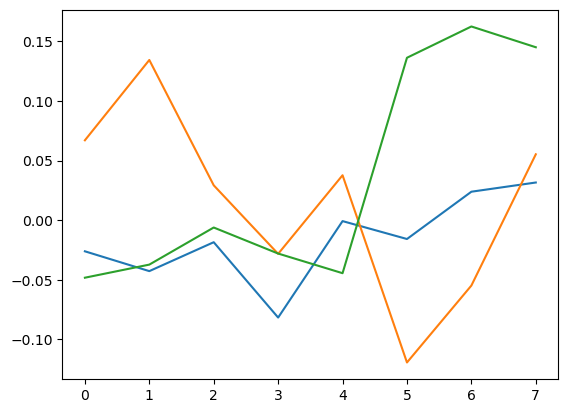

In [13]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.plot(theirs.reshape(8,3)[:,i])

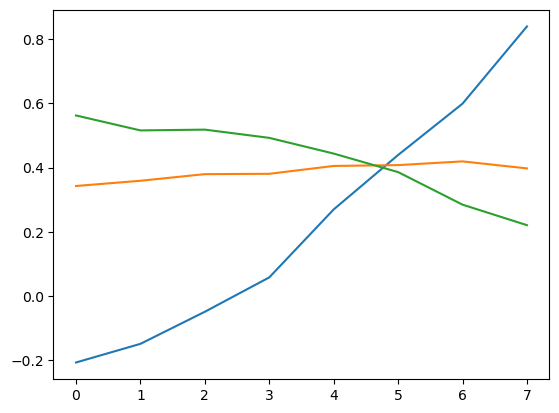

In [23]:
for i in range(3):
    plt.plot(mine[:,:,i])